# Analysis of Brinjal Price Volatility in Odisha from 2012 to 2024

- Code for the paper: https://arxiv.org/abs/2503.11690

In [105]:
# Import necessary libraries for the analysis

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

from arch import arch_model

from statsmodels.tsa.stattools import grangercausalitytests
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [106]:
# Function to optimize EGARCH parameters
def optimize_egarch_parameters(data, p_range, o_range, q_range):
    best_aic = float('inf')
    best_params = None
    best_model = None

    for p in p_range:
        for o in o_range:
            for q in q_range:
                try:
                    model = arch_model(data, vol='EGARCH', p=p, o=o, q=q)
                    fit = model.fit(disp='off')
                    if fit.aic < best_aic:
                        best_aic = fit.aic
                        best_params = {'p': p, 'o': o, 'q': q}
                        best_model = fit
                except Exception as e:
                    print(f"Failed for p={p}, o={o}, q={q}: {e}")
                    continue

    return best_params, best_model

# Function for cross-correlation analysis between dependent and independent variables
def cross_correlation_analysis(series1, series2, max_lag=24):
    cross_corrs = [series1.corr(series2.shift(lag)) for lag in range(-max_lag, max_lag + 1)]
    lags = np.arange(-max_lag, max_lag + 1)
    
    plt.figure(figsize=(12, 4), facecolor='white')
    markerline, _, _ = plt.stem(lags, cross_corrs, linefmt='black', markerfmt='bo', basefmt='black')
    plt.setp(markerline, color='purple', markersize=6)
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.xticks(np.arange(-max_lag, max_lag + 1, step=6), fontweight="bold")
    plt.yticks(fontweight="bold")
    plt.ylim(-0.25, 0.25)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_facecolor('white')
    plt.show()
    
    return pd.DataFrame({'Lag': lags, 'Cross-Correlation': cross_corrs})

# Function to perform Granger Causality Test
def granger_causality_test(df, cause, effect, max_lag=12):
    print(f"\nGranger Causality Test: {cause} -> {effect}")
    test_result = grangercausalitytests(df[[effect, cause]], max_lag, verbose=None)
    return test_result

# Function for hyperparameter tuning SARIMAX model
def auto_arima(y, exog=None, 
               p_range=(0,3), d_range=(0,1), q_range=(0,3), 
               P_range=(0,2), D_range=(0,1), Q_range=(0,2), 
               s=12, criterion="aic"):

    best_score = np.inf
    best_cfg = None

    for order in itertools.product(range(p_range[0], p_range[1]+1),
                                   range(d_range[0], d_range[1]+1),
                                   range(q_range[0], q_range[1]+1)):
        for seasonal_order in itertools.product(range(P_range[0], P_range[1]+1),
                                                range(D_range[0], D_range[1]+1),
                                                range(Q_range[0], Q_range[1]+1),
                                                [s]):

            model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                            exog=exog, enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            score = getattr(fit, criterion)
            
            if score < best_score:
                best_score = score
                best_cfg = (order, seasonal_order)

    return {
        "best_order": best_cfg[0],
        "best_seasonal_order": best_cfg[1],
        f"best_{criterion}": best_score
    }

In [107]:
# # Function to optimize LSTM parameters using Optuna
# def objective(trial):
#     seq_length = trial.suggest_int("seq_length", 12, 36, step=6)
#     train_ratio = trial.suggest_float("train_ratio", 0.5, 0.8, step=0.1)
#     num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 3)
#     lstm_units = trial.suggest_int("lstm_units", 32, 128, step=16)
#     batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
#     epochs = trial.suggest_int("epochs", 50, 500, step=50)
    
#     X = df[["PREC", "MAXTEMP"]].values
#     y = df[["cond_vol"]].values

#     x_scaler, y_scaler = StandardScaler(), StandardScaler()
#     X_scaled = x_scaler.fit_transform(X)
#     y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
    
#     X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
#     train_size = int(train_ratio * len(X_seq))
#     X_train, X_test = X_seq[:train_size], X_seq[train_size:]
#     y_train, y_test = y_seq[:train_size], y_seq[train_size:]
    
#     model = Sequential()
#     for _ in range(num_lstm_layers - 1):
#         model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
#     model.add(LSTM(units=lstm_units))
#     model.add(Dense(1))
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

#     y_pred_scaled = model.predict(X_test)
#     y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
#     y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
#     return mean_absolute_percentage_error(y_test_inv, y_pred_inv)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

## Reading Price and Meteorological Data

In [108]:
data = pd.read_csv("Price_Data/BRINJAL-MODALPRICE-MONTHLY.csv")
data["Price Date"] = pd.to_datetime(data["Price Date"], format="%d-%m-%Y")

data.head()

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
0,2012-01-01,1400.0,966.666667,1250.0,1385.0,1000.0,1475.0
1,2012-02-01,900.0,800.000000,1000.0,1425.0,1800.0,1500.0
2,2012-03-01,600.0,1083.333333,1650.0,925.0,1850.0,825.0
3,2012-04-01,1200.0,875.000000,1000.0,950.0,1250.0,1000.0
4,2012-05-01,1700.0,800.000000,1000.0,1250.0,2000.0,1275.0


In [109]:
prec_data = pd.read_csv("Met_Data/Odisha-Prec-Data.csv")
prec_data['Price Date'] = pd.to_datetime(prec_data['Price Date'], format='%d-%m-%Y')

prec_data.head()

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
0,2012-01-01,79.38,43.01,50.89,24.82,20.59,30.42
1,2012-02-01,5.35,6.77,3.89,0.44,1.18,1.16
2,2012-03-01,1.70,0.52,0.77,0.03,0.89,0.04
3,2012-04-01,104.62,38.17,74.70,74.84,64.66,76.04
4,2012-05-01,29.39,4.23,17.15,53.14,48.28,34.92


In [110]:
tmax_data = pd.read_csv("Met_Data/Odisha-Tmax-Data.csv")
tmax_data['Price Date'] = pd.to_datetime(tmax_data['Price Date'], format='%d-%m-%Y')

tmax_data.head()

,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh
0,2012-01-01,30.36,28.22,29.78,29.51,30.98,30.37
1,2012-02-01,35.48,35.94,37.37,34.93,36.99,37.09
2,2012-03-01,40.18,40.23,41.26,37.15,40.58,40.30
3,2012-04-01,39.70,42.63,42.51,38.26,42.81,41.59
4,2012-05-01,41.19,46.19,44.35,38.19,44.82,42.47


## Data Analysis and Visualisations

In [111]:
data["State_Mean"] = data.iloc[:, 1:].mean(axis=1) # mean modal price across all districts
data["State_std"] = data.iloc[:, 1:].std(axis=1) # standard deviation of modal price across all districts
data["State_Mean_LogReturns"] = np.log(data["State_Mean"]) - np.log(data["State_Mean"].shift(1)) # log returns of modal price across all districts
data["State_Mean_Squared_LogReturns"] = data["State_Mean_LogReturns"]**2

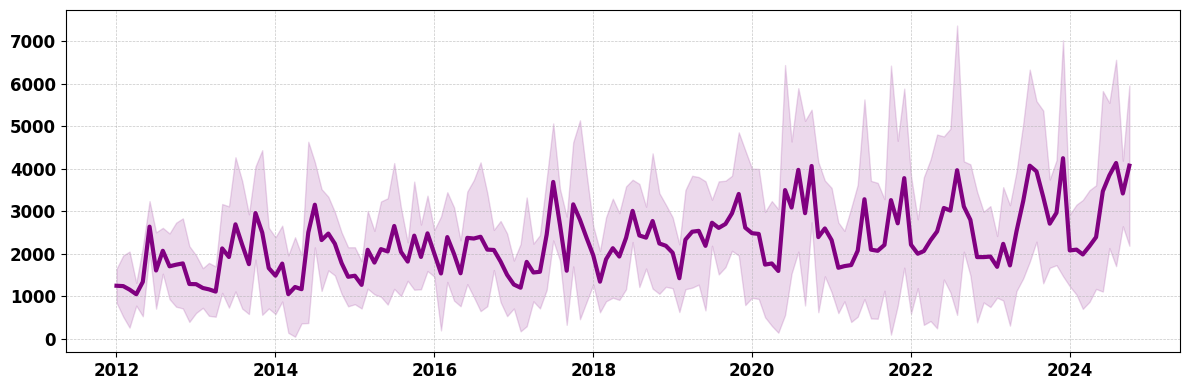

In [112]:
# Plotting the mean modal price of Soybean with standard deviation

plt.figure(figsize=(12, 4))

plt.plot(data['Price Date'], data['State_Mean'], color="purple", linewidth=3)
plt.fill_between(data['Price Date'],
                 data['State_Mean'] - 2 * data['State_std'],
                 data['State_Mean'] + 2 * data['State_std'],
                 alpha=0.15, color="purple")

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Brinjal-price-Odisha.png", dpi=600, bbox_inches='tight')
plt.show()

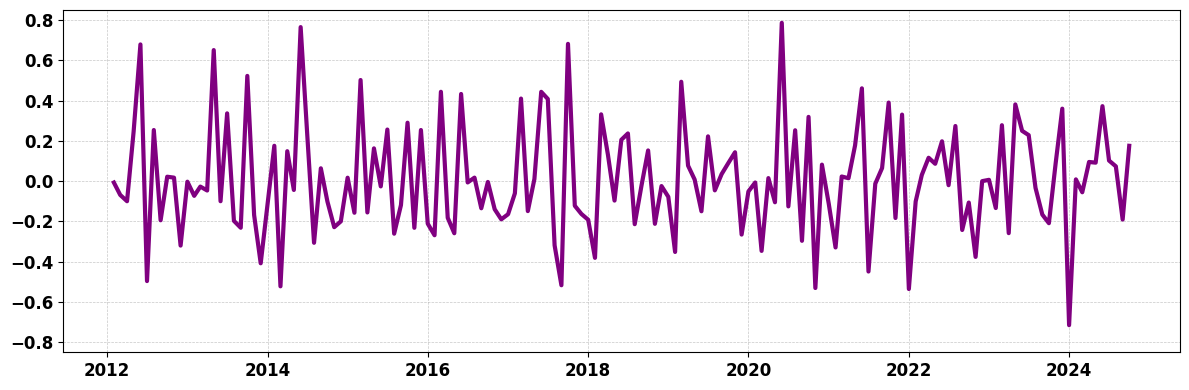

In [113]:
# Plotting the log returns of the modal price of Brinjal

plt.figure(figsize=(12, 4))

plt.plot(data['Price Date'], data['State_Mean_LogReturns'], color="purple", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(-0.85, 0.85)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Brinjal-logreturns-Odisha.png", dpi=600, bbox_inches='tight')
plt.show()

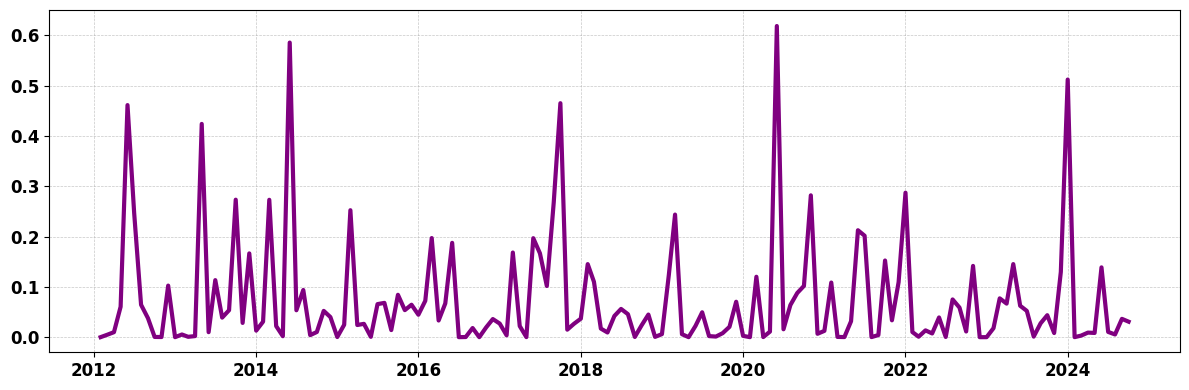

In [114]:
# Plotting the log returns of the modal price of Soybean

plt.figure(figsize=(12, 4))

plt.plot(data['Price Date'], data['State_Mean_Squared_LogReturns'], color="purple", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(-0.03, 0.65)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Brinjal-squared-logreturns-Odisha.png", dpi=600, bbox_inches='tight')
plt.show()

In [115]:
print(f"Skewness: {skew(data['State_Mean_LogReturns'].dropna())}") # skewness
print(f"Kurtosis: {kurtosis(data['State_Mean_LogReturns'].dropna())}") # kurtosis
data.describe() # descriptive statistics

Skewness: 0.3888650485827129
Kurtosis: 0.2779284833073259


,Price Date,Balasore,Bargarh,Dhenkanal,Ganjam,Kalahandi,Nayagarh,State_Mean,State_std,State_Mean_LogReturns,State_Mean_Squared_LogReturns
count,154,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,153.000000,153.000000
mean,2018-05-17 03:44:24.935064832,2196.374459,1557.775974,2775.757576,2457.781385,2521.266234,2202.022727,2285.163059,624.986284,0.007744,0.074444
min,2012-01-01 00:00:00,600.000000,450.000000,1000.000000,500.000000,950.000000,575.000000,1045.833333,134.177018,-0.715420,0.000000
25%,2015-03-08 18:00:00,1481.250000,1061.666667,2000.000000,1900.000000,2000.000000,1481.250000,1757.638889,432.289608,-0.168335,0.006065
50%,2018-05-16 12:00:00,2127.083333,1416.666667,2750.000000,2325.000000,2162.500000,2000.000000,2186.805556,584.833137,-0.012671,0.030831
75%,2021-07-24 06:00:00,2745.833333,1843.750000,3393.750000,3000.000000,3000.000000,2637.500000,2676.041667,760.561178,0.175589,0.087816
max,2024-10-01 00:00:00,5800.000000,4300.000000,5750.000000,6000.000000,6200.000000,5200.000000,4250.000000,1703.835542,0.786238,0.618170
std,NaN,887.524318,693.695616,1063.835927,906.428527,1047.088956,969.172984,744.219095,274.355657,0.273630,0.113801


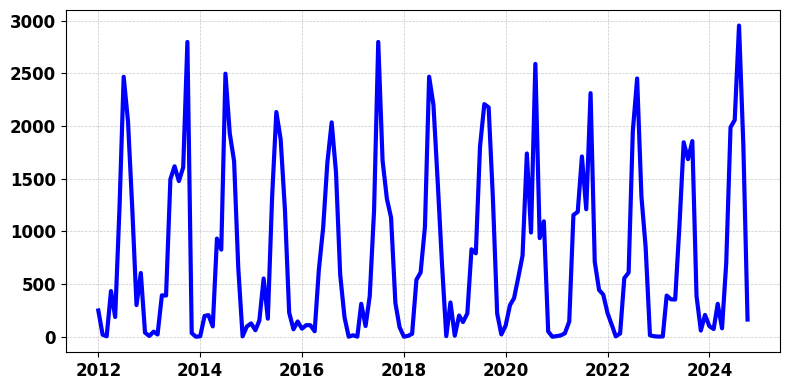

In [116]:
prec_data["SUM_PRECTOTCORR"] = prec_data.iloc[:, 1:].sum(axis=1) # sum of precipitation across all districts

plt.figure(figsize=(8, 4))

plt.plot(prec_data['Price Date'], prec_data['SUM_PRECTOTCORR'], color="blue", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Prec-Odisha-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

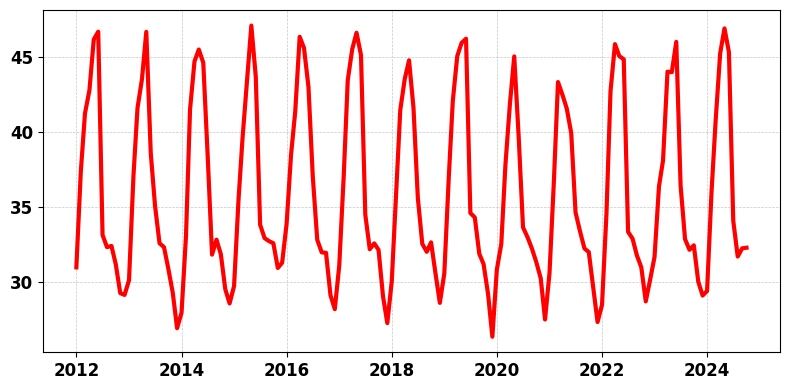

In [117]:
tmax_data["MAX_T2M_MAX"] = tmax_data.iloc[:, 1:].max(axis=1) # maximum temperature across all districts

plt.figure(figsize=(8, 4))

plt.plot(tmax_data['Price Date'], tmax_data['MAX_T2M_MAX'], color="red", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Tmax-Odisha-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

## Applying EGARCH model on Log Returns of Modal Price

In [118]:
# Optimizing the parameters and fitting the EGARCH model on the modal price log returns
params, _ = optimize_egarch_parameters(data["State_Mean_LogReturns"].dropna(), p_range=[1, 2, 3], o_range=[1, 2, 3], q_range=[1, 2, 3])

model = arch_model(data["State_Mean_LogReturns"].dropna(), vol='EGARCH', p=params['p'], o=params['o'], q=params['q'])
garch_fit = model.fit()
print(garch_fit.summary())

c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Abbin\AppData

Iteration:      1,   Func. Count:     10,   Neg. LLF: 845241241.4847373
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1018324446.0033762
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5130860870495.307
Iteration:      4,   Func. Count:     48,   Neg. LLF: 331.4456774455032
Iteration:      5,   Func. Count:     59,   Neg. LLF: 48977039.705252744
Iteration:      6,   Func. Count:     69,   Neg. LLF: 822.0105479222593
Iteration:      7,   Func. Count:     79,   Neg. LLF: 1059618.4022169362
Iteration:      8,   Func. Count:     90,   Neg. LLF: 3829508.715531187
Iteration:      9,   Func. Count:    101,   Neg. LLF: 4188713.1258654455
Iteration:     10,   Func. Count:    112,   Neg. LLF: 184718841.2090559
Iteration:     11,   Func. Count:    123,   Neg. LLF: 419824429.65736437
Iteration:     12,   Func. Count:    135,   Neg. LLF: 202454201.07364017
Iteration:     13,   Func. Count:    146,   Neg. LLF: 10506097.729202282
Iteration:     14,   Func. Count:    156,   Neg. LLF: 450

c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


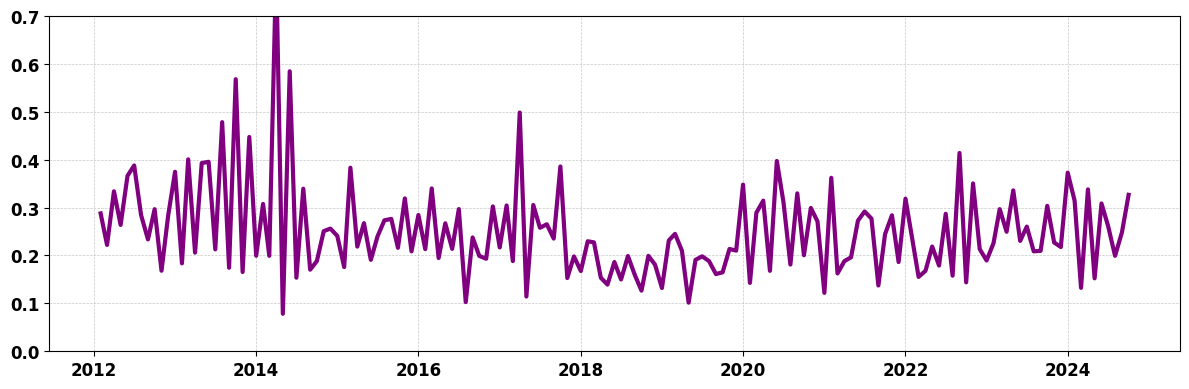

In [119]:
# Plotting the conditional volatility obtained from EGARCH

data["State_Mean_LogReturns_CondVol"] = garch_fit.conditional_volatility

plt.figure(figsize=(12, 4))

plt.plot(data["Price Date"], data["State_Mean_LogReturns_CondVol"], color="purple", linewidth=3)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 0.7)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("images/Brinjal-condvol-Odisha.png", dpi=600, bbox_inches='tight')
plt.show()

In [120]:
df = pd.DataFrame() # Preparing dataframe for modelling
df["Price Date"] = data["Price Date"].iloc[1:]
df["Price Date"] = pd.to_datetime(df["Price Date"], format="%d-%m-%Y")

df["cond_vol"] = data["State_Mean_LogReturns_CondVol"].iloc[1:] # Dependent variable
df["PREC"] = prec_data["SUM_PRECTOTCORR"].iloc[1:] # independent variable
df["MAXTEMP"] = tmax_data["MAX_T2M_MAX"].iloc[1:] # independent variable

df["cond_vol_diff"] = df["cond_vol"] - df["cond_vol"].shift(1) # Differencing to obtain stationarity time series for Granger Causality analysis

Cross-Correlation: Volatility vs Max Temperature


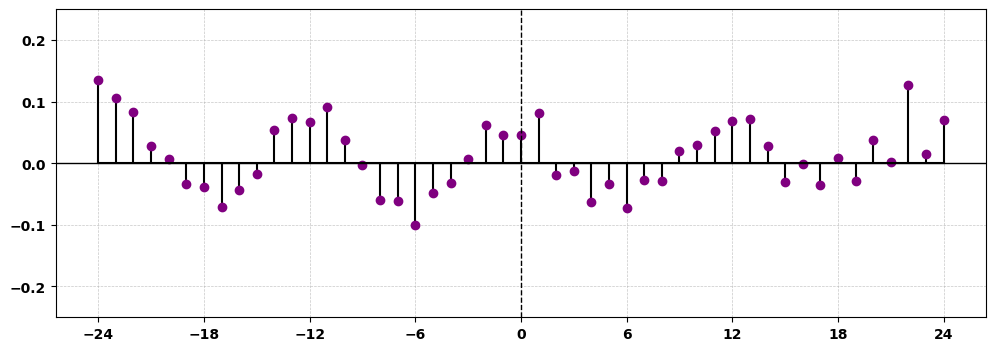

Cross-Correlation: Volatility vs Precipitation


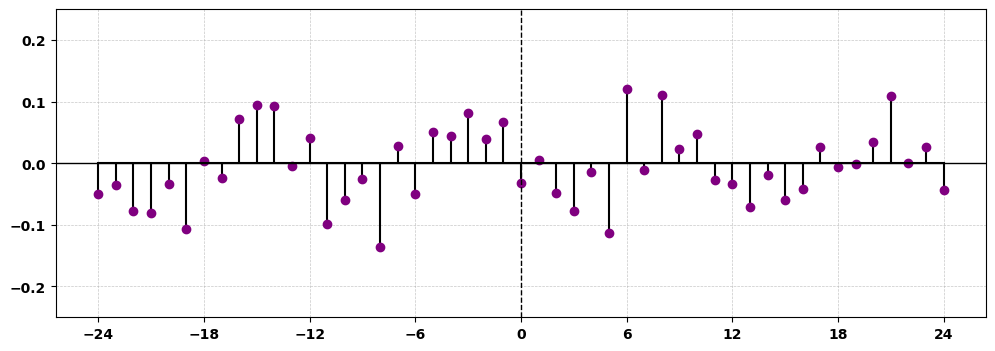


Granger Causality Test: MAXTEMP -> cond_vol_diff

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1961  , p=0.6585  , df_denom=148, df_num=1
ssr based chi2 test:   chi2=0.2001  , p=0.6546  , df=1
likelihood ratio test: chi2=0.2000  , p=0.6547  , df=1
parameter F test:         F=0.1961  , p=0.6585  , df_denom=148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7803  , p=0.1722  , df_denom=145, df_num=2
ssr based chi2 test:   chi2=3.6835  , p=0.1585  , df=2
likelihood ratio test: chi2=3.6390  , p=0.1621  , df=2
parameter F test:         F=1.7803  , p=0.1722  , df_denom=145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4402  , p=0.2336  , df_denom=142, df_num=3
ssr based chi2 test:   chi2=4.5337  , p=0.2093  , df=3
likelihood ratio test: chi2=4.4661  , p=0.2153  , df=3
parameter F test:         F=1.4402  , p=0.2336  , df_denom=142, df_num=3

Granger Causality
number of lags (no zero) 

{np.int64(1): ({'ssr_ftest': (np.float64(0.31736708281440446),
    np.float64(0.5740467670841205),
    np.float64(148.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.3238001993579397),
    np.float64(0.5693327647323182),
    np.int64(1)),
   'lrtest': (np.float64(0.3234535208049465),
    np.float64(0.5695395597642086),
    np.int64(1)),
   'params_ftest': (np.float64(0.31736708281442627),
    np.float64(0.5740467670841106),
    np.float64(148.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.35259395683902295),
    np.float64(0.7034634698407822),
    np.float64(145.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.7295047382876336),
    np.float64(0.6943685766751828),
    np.int64(2)),
   'lrtest': (np.float64(0.727736545005655),
    np.float64(0.6949827370499884),
    np.int64(2)),
   'params_ftest': (np.float64(0.3525939568343266),
    np.float64(0.7034634698440767),
    np.float64(145.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
    

In [121]:
# Conduct cross-correlation analysis
print("Cross-Correlation: Volatility vs Max Temperature")
cc_temp = cross_correlation_analysis(df['cond_vol'], df['MAXTEMP'])

print("Cross-Correlation: Volatility vs Precipitation")
cc_prec = cross_correlation_analysis(df['cond_vol'], df['PREC'])

# Conduct granger causality test
granger_causality_test(df.dropna(), 'MAXTEMP', 'cond_vol_diff')
granger_causality_test(df.dropna(), 'PREC', 'cond_vol_diff')

## Modelling: ARIMAX and LSTM

### SARIMAX Model

In [122]:
# Training - test split: 60% - 40%
train = df[ : int(0.6*len(df))]
train["Price Date"] = pd.to_datetime(train["Price Date"], format="%d-%m-%Y")

test = df[int(0.6*len(df)) : ]
test["Price Date"] = pd.to_datetime(test["Price Date"], format="%d-%m-%Y")

C:\Users\Abbin\AppData\Local\Temp\ipykernel_7844\630167101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Price Date"] = pd.to_datetime(train["Price Date"], format="%d-%m-%Y")
C:\Users\Abbin\AppData\Local\Temp\ipykernel_7844\630167101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Price Date"] = pd.to_datetime(test["Price Date"], format="%d-%m-%Y")


In [123]:
best_params = auto_arima(train["cond_vol"], exog=train[["PREC", "MAXTEMP"]],
                         p_range=(0,3), d_range=(0,1), q_range=(0,3),
                         P_range=(0,2), D_range=(0,1), Q_range=(0,2),
                         s=12, criterion="aic")

print("Best SARIMAX Order:", best_params["best_order"])
print("Best Seasonal Order:", best_params["best_seasonal_order"])
print("Best AIC:", best_params["best_aic"])

c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

Best SARIMAX Order: (1, 1, 1)
Best Seasonal Order: (0, 0, 0, 12)
Best AIC: -163.89803912911955


In [124]:
# Fitting the SARIMAX model on the conditional volatility

sarimax_model = SARIMAX(train["cond_vol"], order=best_params["best_order"], seasonal_order=best_params["best_seasonal_order"], exog=train[["PREC", "MAXTEMP"]])
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               cond_vol   No. Observations:                   91
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  88.939
Date:                Fri, 26 Sep 2025   AIC                           -167.879
Time:                        02:37:47   BIC                           -155.380
Sample:                             0   HQIC                          -162.838
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PREC        4.751e-06   1.19e-05      0.400      0.689   -1.85e-05     2.8e-05
MAXTEMP        0.0024      0.001      1.658      0.097      -0.000       0.005
ar.L1         -0.7050      0.099     -7.147      0.0

c:\Users\Abbin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


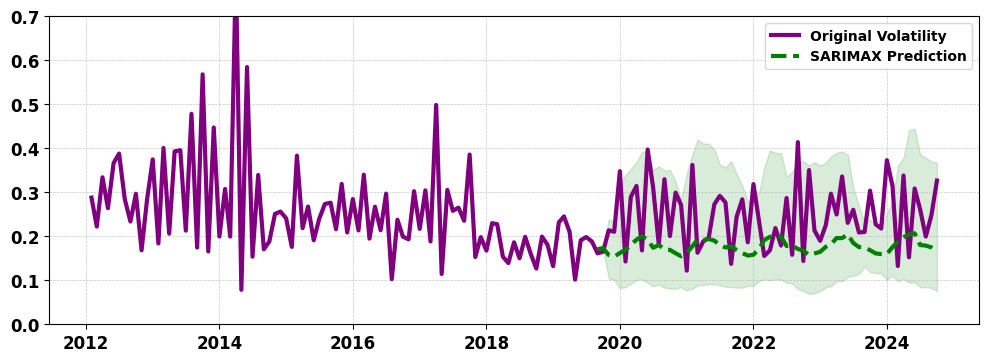

MAPE (test): 0.29625303987980467


In [125]:
# Plotting the SARIMAX forecast with 95% confidence interval

sarimax_forecast = sarimax_fit.predict(start=len(train), end=len(df)-1, exog=test[["PREC", "MAXTEMP"]])

residuals = np.log(test["cond_vol"]) - np.log(sarimax_forecast)
rolling_std = residuals.rolling(window=10, min_periods=1).std()

upper_bound_sarimax = sarimax_forecast * np.exp(2 * rolling_std)
lower_bound_sarimax = sarimax_forecast * np.exp(-2 * rolling_std)

plt.figure(figsize=(12, 4))

plt.plot(df["Price Date"], df["cond_vol"], color='purple', label="Original Volatility", linewidth=3)
plt.plot(test["Price Date"], sarimax_forecast, color='green', linestyle="--", label="SARIMAX Prediction", linewidth=3)
plt.fill_between(test["Price Date"], lower_bound_sarimax, upper_bound_sarimax, color='green', alpha=0.15)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 0.7)
plt.legend(fontsize=12, prop={'weight': 'bold'})
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig("images/Brinjal-sarimax-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()

mape = mean_absolute_percentage_error(test["cond_vol"], sarimax_forecast)
print(f"MAPE (test): {mape}")

### LSTM model

In [126]:
# Function to create sequences for LSTM model
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

In [127]:
best_params = {'seq_length': 24, 'train_ratio': 0.52, 'num_lstm_layers': 2, 'lstm_units': 128, 'batch_size': 8, 'learning_rate': 0.0017076049468726104, 'epochs': 300}

X = df[["PREC", "MAXTEMP"]].values # independent variables
y = df[["cond_vol"]].values # dependent variable

# Standardizing the data
x_scaler, y_scaler = StandardScaler(), StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

# Creating sequences and splitting train - test: 60% - 40%
seq_length = best_params['seq_length']
train_ratio = best_params['train_ratio']
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

train_size = int(train_ratio * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [128]:
# # Build LSTM Model
# model = Sequential()
# for _ in range(best_params['num_lstm_layers'] - 1):
#     model.add(LSTM(units=best_params['lstm_units'], return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
# model.add(LSTM(units=best_params['lstm_units']))
# model.add(Dense(1))

# optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
# model.compile(loss='mean_squared_error', optimizer=optimizer)

# # Saving the best LSTM model
# checkpoint_path = "Odisha_Brinjal_Best_Weights_LSTM.h5"
# checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min', verbose=1)
# history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params["batch_size"], verbose=1, callbacks=[checkpoint])

# model.save("Odisha_Brinjal_Best_Model_LSTM.h5")
# print("Best model saved successfully!")

In [129]:
# Loading the best LSTM model and predicting for test data

model = load_model("MP_Soybean_Best_Model_LSTM.h5")
print("Best model loaded successfully!")

y_pred_scaled = model.predict(X_test)

y_train_inv = y_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("Actual yield:", y_test_inv.flatten())
print("Predicted Yield: ", y_pred_inv.flatten())
print(f"MAPE (Test): {mape_test:.2f}%")

Best model loaded successfully!
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 911ms/step
Actual yield: [0.16122525 0.16487482 0.21357511 0.21014265 0.34799735 0.14274961
 0.28937993 0.31451365 0.16796125 0.39730098 0.31100934 0.18106658
 0.3296982  0.20048895 0.29926636 0.27126116 0.12192032 0.36216502
 0.16250819 0.18812801 0.19623958 0.27273837 0.29187303 0.27693145
 0.13735433 0.24445559 0.28397893 0.18635999 0.31861322 0.2321643
 0.15526588 0.16805684 0.21870942 0.17892398 0.28702501 0.15783037
 0.41403948 0.14393172 0.35047885 0.21327063 0.18954061 0.2255962
 0.29679458 0.24948423 0.33590639 0.23045016 0.26029996 0.20869149
 0.20971263 0.3035999  0.22717921 0.21765229 0.37281722 0.31437621
 0.13244331 0.33802088 0.15230384 0.30859756 0.26109101 0.19929701
 0.24825809 0.32662599]
Predicted Yield:  [0.20644006 0.21506616 0.21902618 0.20420572 0.18585369 0.17123313
 0.16057579 0.15493138 0.15745582 0.16986477 0.18311127 0.18115045
 0.20336492 0.21199672 0.20298114 0.17748941 0.1595907  0.14667767
 0.1

In [130]:
# Plotting the LSTM forecast with 95% confidence interval

y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()

residuals = pd.Series(np.log(y_test_inv) - np.log(y_pred_inv))
rolling_std = residuals.rolling(window=10, min_periods=1).std()

upper_bound_lstm = y_pred_inv * np.exp(2 * rolling_std)
lower_bound_lstm = y_pred_inv * np.exp(-2 * rolling_std)

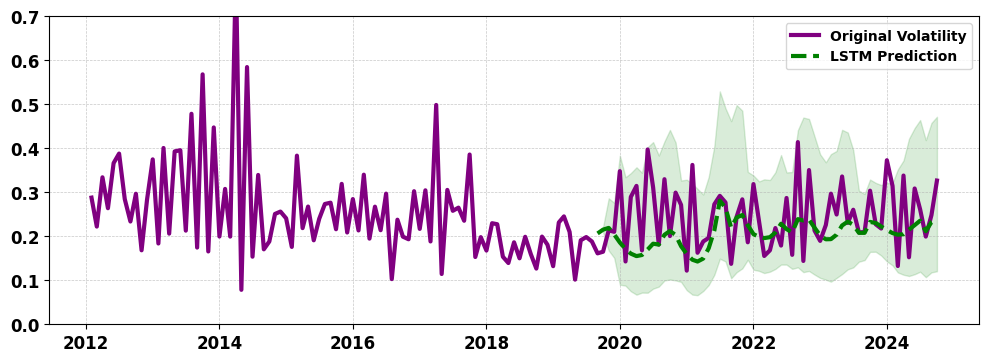

In [131]:
plt.figure(figsize=(12, 4))

price_dates = df["Price Date"].iloc[-len(y_test_inv):].values
price_dates = pd.to_datetime(price_dates, format="%d-%m-%Y")

plt.plot(df["Price Date"], df["cond_vol"], label="Original Volatility", color="purple", linestyle="-", linewidth=3)
plt.plot(price_dates, y_pred_inv, label="LSTM Prediction", color="green", linestyle="dashed", linewidth=3)
plt.fill_between(price_dates, upper_bound_lstm, lower_bound_lstm, color="green", alpha=0.15)

plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')
plt.ylim(0, 0.7)
plt.legend(fontsize=12, prop={'weight': 'bold'})
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig("images/Brinjal-lstm-Statelevel.png", dpi=600, bbox_inches='tight')
plt.show()